## IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.cm import get_cmap
import matplotlib.ticker as ticker
import seaborn as sns
import shap

import statsmodels
import statsmodels.api as sm
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway, pointbiserialr
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

import re
import pickle
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)

## LOAD DATASET

In [2]:
df = pd.read_csv('File CSV/Car_Price_Prediction.csv')
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,smart,ForTwo Pure,2008,"61,595 mi.",Gasoline,70.0HP 1.0L 3 Cylinder Engine Gasoline Fuel,5-Speed A/T,Blue,Gray,None reported,Yes,"$5,000"
1,Volvo,XC90 Hybrid T8 R-Design,2018,"40,000 mi.",Plug-In Hybrid,400.0HP 2.0L 4 Cylinder Engine Plug-In Electri...,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,"$42,000"
2,Volvo,XC90 3.2,2011,"88,300 mi.",Gasoline,235.0HP 3.2L Straight 6 Cylinder Engine Gasoli...,A/T,Blue,Beige,At least 1 accident or damage reported,Yes,"$11,500"
3,Volvo,S90 T5 Momentum,2018,"95,000 mi.",Gasoline,250.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Beige,None reported,Yes,"$18,000"
4,Volvo,XC90 T6 Momentum,2018,"110,380 mi.",Gasoline,316.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Beige,At least 1 accident or damage reported,Yes,"$22,000"


In [3]:
total_cylinder = pd.read_excel('File CSV/Total_Cylinder.xlsx')
horse_power = pd.read_excel('File CSV/Horse_Power.xlsx')
engine_capacity = pd.read_csv('File CSV/Engine_Capacity.csv')
fuel_type = pd.read_csv('File CSV/Fuel_Type.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


## DATA PREPROCESSING

In [5]:
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [6]:
pd.isnull(df).sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

In [7]:
df.drop(columns=['clean_title', 'model_year'], inplace=True)
df.dropna(inplace=True)

In [8]:
df.duplicated().sum()

0

## FEATURE EXTRACTION

## BRAND FEATURE

In [9]:
df['brand'] = df['brand'].replace({'smart': 'Smart'})

In [10]:
categories = {
    'Smart': 'Compact', 'Volvo': 'Luxury', 'Volkswagen': 'Compact', 'Toyota': 'Sedan', 'Suzuki': 'Compact', 'Subaru': 'SUV', 'Scion': 'Compact', 'Saturn': 'Compact',
    'Saab': 'Luxury', 'Rolls-Royce': 'Luxury', 'RAM': 'Pick Up', 'Porsche': 'Luxury', 'Pontiac': 'Compact', 'Plymouth': 'Compact', 'Nissan': 'Sedan', 'Mitsubishi': 'SUV',
    'Mercury': 'Compact', 'Mercedes-Benz': 'Luxury', 'McLaren': 'Sports', 'Mazda': 'Compact', 'Maybach': 'Luxury', 'Maserati': 'Luxury', 'MINI': 'Compact', 'Lotus': 'Sports',
    'Lincoln': 'Luxury', 'Lexus': 'Luxury', 'Land': 'SUV', 'Lamborghini': 'Sports', 'Kia': 'Sedan', 'Jeep': 'SUV', 'Jaguar': 'Luxury', 'INFINITI': 'Luxury', 
    'Hyundai': 'Sedan', 'Hummer': 'SUV', 'Honda': 'Sedan', 'Genesis': 'Luxury', 'GMC': 'Pick Up', 'Ford': 'Sedan', 'Ferrari': 'Sports', 'FIAT': 'Compact', 'Dodge': 'Sedan',
    'Chrysler': 'Sedan', 'Chevrolet': 'Sedan', 'Cadillac': 'Luxury', 'Buick': 'Luxury', 'Bugatti': 'Sports', 'Bentley': 'Luxury', 'BMW': 'Luxury', 'Audi': 'Luxury',
    'Aston': 'Luxury', 'Alfa': 'Luxury', 'Acura': 'Luxury'
}

df['product_category'] = df['brand'].map(categories)

## MILAGE FEATURE

In [11]:
df['milage'] = df['milage'].str.replace(' mi.', '').str.replace(',', '').astype(int)

## FUEL TYPE FEATURE

In [12]:
df[df['fuel_type']=='–'].head()

,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price,product_category
22,Volvo,850 Turbo,94000,–,–,A/T,White,Black,None reported,"$4,500",Luxury
111,Toyota,Land Cruiser Base,231500,–,–,A/T,White,Gray,None reported,"$29,500",Sedan
163,Toyota,Land Cruiser Base,233000,–,–,A/T,Blue,Gray,None reported,"$7,500",Sedan
295,Toyota,Land Cruiser Base,178416,–,–,A/T,Green,Beige,None reported,"$9,000",Sedan
469,Rolls-Royce,Phantom,1560,–,–,–,Tempest,Cobalt Blue,None reported,"$599,995",Luxury


In [13]:
rows_to_replace = df['fuel_type'] == '–'
fuel_type_mapping = fuel_type.set_index('Model')['Fuel Type'].to_dict()
df.loc[rows_to_replace, 'fuel_type'] = df.loc[rows_to_replace, 'model'].map(fuel_type_mapping)

In [14]:
fuel_type_updates = [
    (239, 'Hydrogen'),
    (279, 'Hydrogen')
]

for index, value in fuel_type_updates:
    df.loc[index, 'fuel_type'] = value

## ENGINE FEATURE

### EXTRACT TO HORSE POWER (HP)

In [15]:
df[df['engine']=='–'].head()

,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price,product_category
22,Volvo,850 Turbo,94000,Gasoline,–,A/T,White,Black,None reported,"$4,500",Luxury
111,Toyota,Land Cruiser Base,231500,Gasoline,–,A/T,White,Gray,None reported,"$29,500",Sedan
163,Toyota,Land Cruiser Base,233000,Gasoline,–,A/T,Blue,Gray,None reported,"$7,500",Sedan
295,Toyota,Land Cruiser Base,178416,Gasoline,–,A/T,Green,Beige,None reported,"$9,000",Sedan
469,Rolls-Royce,Phantom,1560,Gasoline,–,–,Tempest,Cobalt Blue,None reported,"$599,995",Luxury


In [16]:
df['horse_power'] = df['engine'].str.extract('(\d+\.\d+)HP', expand=False)
df['horse_power'] = df['horse_power'].str.replace('.0', '').str.replace(',', '')

In [17]:
horse_power_mapping = horse_power.set_index('Model')['Horsepower'].to_dict()
df['horse_power'] = df['horse_power'].fillna(df['model'].map(horse_power_mapping))

In [18]:
df['horse_power'] = df['horse_power'].astype('int64')

### EXTRACT TO ENGINE CAPACITY (LITER)

In [19]:
df['engine_capacity'] = df['engine'].str.extract(r'(\d+\.\d+L|\d+ Liter)', expand=False)
df['engine_capacity'].replace({'L': '', 'Liter': '', 'iter': ''}, regex=True, inplace=True)
df['engine_capacity'] = df['engine_capacity'].astype(float).round(1)

In [20]:
values_to_update = {
    232: 4, 240: 4, 408: 2, 412: 2, 722: 4, 966: 3, 1023: 2, 1336: 3, 1637: 5, 1662: 5, 1762: 4, 3327: 4, 3334: 4, 1784: 2, 1915: 2, 2672: 6.7, 3335: 6, 3434: 3, 3491: 2, 3823: 3, 
    3934: 2, 43: 2, 53: 2, 92: 2, 100: 2, 107: 5.7, 200: 3.5, 224: 3.5, 251: 3.5, 255: 3.5, 263: 3.5, 599: 3, 601: 3, 609: 2, 612: 3, 621: 3, 652: 3, 687: 2, 689: 2.9, 690: 3, 736: 4,
    800: 1.8, 808: 5.6, 828: 5.6, 876: 3.5, 947: 2, 949: 3, 951: 4.7, 967: 4, 974: 3, 983: 2, 1011: 3, 1025: 4, 1031: 4, 1033: 5.5, 1035: 4, 1052: 3, 1093: 2, 1095: 2, 1099: 2, 1101: 3,
    1102: 3, 1135: 3, 1163: 2, 1180: 2, 1197: 2, 1211: 2, 1228: 2, 1235: 2, 1242: 2, 1266: 2.5, 1283: 1.3, 1300: 1.3, 1317: 1.3, 1399: 3, 1450: 3.5, 1459: 2.4, 1477: 4.6, 1492: 3.5,
    1495: 3.5, 1499: 3.5, 1511: 4.6, 1553: 3.5, 1562: 3.5, 1568: 3.5, 1581: 2.5, 1589: 2.5, 1615: 2, 1621: 3, 1622: 2, 1623: 3, 1625: 4.4, 1628: 2, 1629: 3, 1631: 2, 1634: 2, 1639: 2,
    1641: 2, 1647: 4.4, 1648: 5, 1652: 3, 1657: 3, 1854: 6.4, 1873: 3.6, 1874: 3.6, 1910: 3.6, 1990: 2, 1997: 3, 1999: 3, 2004: 2, 2008: 3, 2009: 2, 2032: 2, 2184: 3.5, 2206: 3.5,
    2370: 5.4, 2374: 3.5, 2396: 5.4, 2801: 6.4, 2857: 3.6, 2929: 5.3, 2963: 6.2, 3139: 2.7, 3183: 3.6, 3217: 3.6, 3328: 6, 3343: 3, 3346: 3, 3348: 4.4, 3350: 3, 3357: 2, 3359: 4.4, 3361: 3,
    3367: 4.4, 3372: 2, 3375: 3, 3379: 2, 3385: 3, 3390: 4.4, 3408: 2, 3409: 4.4, 3412: 4.4, 3418: 3, 3421: 4.4, 3422: 3, 3424: 4.4, 3427: 4.4, 3468: 4.4, 3470: 6.6, 3572: 2, 3585: 4.4,
    3586: 2, 3589: 3, 3596: 3, 3612: 3, 3615: 3, 3728: 3, 3738: 2, 3742: 2, 3757: 4, 3764: 4, 3776: 2, 3804: 3, 3815: 3, 3816: 3, 3822: 3, 3832: 2, 3845: 2, 3847: 2, 3849: 2, 3856: 2,
    3864: 2, 3876: 2, 3880: 2, 3908: 2, 3945: 2.4, 3947: 1.5, 3949: 2, 3953: 3.5, 3975: 2, 3976: 2, 3978: 2, 3981: 2, 3987: 3.5, 3990: 2, 4000: 3.5, 4002: 3.5
}

df['engine_capacity'].update(pd.Series(values_to_update))

In [21]:
engine_capacity_mapping = engine_capacity.set_index('Model')['Total Engine Capacity (Liters)'].to_dict()
df['engine_capacity'] = df['engine_capacity'].fillna(df['model'].map(engine_capacity_mapping))

### EXTRACT TO TOTAL CYLINDER

In [22]:
df['total_cylinder'] = df['engine'].str.extract(r'L\s*([^,]+)', expand=False)

In [23]:
engine_type_updates = [
    (239, 'Electric Motor Hydrogen Fuel'),
    (279, 'Electric Motor Hydrogen Fuel'),
    (3328, '12 Cylinder Engine'),
    (2672, 'Intercooled Turbo Diesel V-8'),
    (3491, 'Intercooled Turbo Premium Unleaded I-4')
]

for index, value in engine_type_updates:
    df.loc[index, 'total_cylinder'] = value

In [24]:
def extract_cylinder_type(engine_type):
    if pd.isna(engine_type):
        return None
    
    match = re.search(r'(\d+)\s*Cylinder', engine_type)
    
    if match:
        return int(match.group(1))
    
    if 'I3' in engine_type:
        return 3
    elif 'I4' in engine_type or 'I-4' in engine_type:
        return 4
    elif 'I6' in engine_type or 'I-6' in engine_type:
        return 6
    elif 'V-6' in engine_type or 'V6' in engine_type:
        return 6
    elif 'H-4' in engine_type or 'H4' in engine_type:
        return 4
    elif 'H6' in engine_type or 'H-6' in engine_type:
        return 6
    elif 'V-8' in engine_type or 'V8' in engine_type:
        return 8
    elif 'V10' in engine_type or 'V-10' in engine_type:
        return 10
    elif 'V12' in engine_type or 'V-12' in engine_type:
        return 12
    elif 'W12' in engine_type or 'W-12' in engine_type:
        return 12
    elif 'W16' in engine_type:
        return 16
    else:
        return pd.NA
    
    return engine_type

df['total_cylinder'] = df['total_cylinder'].astype(str)
df['total_cylinder'] = df['total_cylinder'].apply(extract_cylinder_type)

In [25]:
df['total_cylinder'] = df['total_cylinder'].fillna(df['model'].map(total_cylinder.set_index('Model Mobil')['Jumlah Silinder']))

## TRANSMISSION

In [26]:
df['transmission_group'] = 'Other'

df.loc[df['transmission'].str.contains('Automatic|A/T|Auto|Transmission', case=False), 'transmission_group'] = 'Automatic'
df.loc[df['transmission'].str.contains('Manual|M/T|6-Speed|7-Speed|2', case=False), 'transmission_group'] = 'Manual'
df.loc[df['transmission'].str.contains('Dual-Clutch', case=False), 'transmission_group'] = 'Dual-Clutch'
df.loc[df['transmission'].str.contains('CVT|Variable', case=False), 'transmission_group'] = 'CVT'

df['transmission'] = df['transmission_group']
df.drop('transmission_group', axis=1, inplace=True)

In [27]:
values_to_update = {
    200: 'Automatic',
    251: 'Automatic',
    469: 'Automatic',
    599: 'Dual-Clutch',
    612: 'Dual-Clutch',
    1459: 'Automatic',
    2421: 'Automatic',
    3612: 'Automatic',
    3945: 'CVT',
    3953: 'Automatic'
}

df['transmission'].update(pd.Series(values_to_update))

## PRICE

In [28]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(int)

## ADDITIONAL CLEANING PROCESS

In [29]:
df['milage'] = df['milage'].astype('int64')
df['price'] = df['price'].astype('int64')
df['engine_capacity'] = df['engine_capacity'].astype('int64')
df['total_cylinder'] = df['total_cylinder'].astype('int64')

In [30]:
df.drop(columns=['engine', 'model', 'ext_col', 'int_col'], inplace=True)

In [31]:
col_order = ['product_category', 'brand', 'milage', 'horse_power', 'engine_capacity', 'total_cylinder', 'fuel_type', 'transmission', 'accident', 'price']
df = df[col_order]

In [32]:
df.head()

,product_category,brand,milage,horse_power,engine_capacity,total_cylinder,fuel_type,transmission,accident,price
0,Compact,Smart,61595,70,1,3,Gasoline,Automatic,None reported,5000
1,Luxury,Volvo,40000,400,2,4,Plug-In Hybrid,Automatic,None reported,42000
2,Luxury,Volvo,88300,235,3,6,Gasoline,Automatic,At least 1 accident or damage reported,11500
3,Luxury,Volvo,95000,250,2,4,Gasoline,Automatic,None reported,18000
4,Luxury,Volvo,110380,316,2,4,Gasoline,Automatic,At least 1 accident or damage reported,22000


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3730 entries, 0 to 4008
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product_category  3730 non-null   object
 1   brand             3730 non-null   object
 2   milage            3730 non-null   int64 
 3   horse_power       3730 non-null   int64 
 4   engine_capacity   3730 non-null   int64 
 5   total_cylinder    3730 non-null   int64 
 6   fuel_type         3730 non-null   object
 7   transmission      3730 non-null   object
 8   accident          3730 non-null   object
 9   price             3730 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 449.6+ KB


## EXPLORATORY DATA ANALYSIS

### UNIVARIATE ANALYSIS

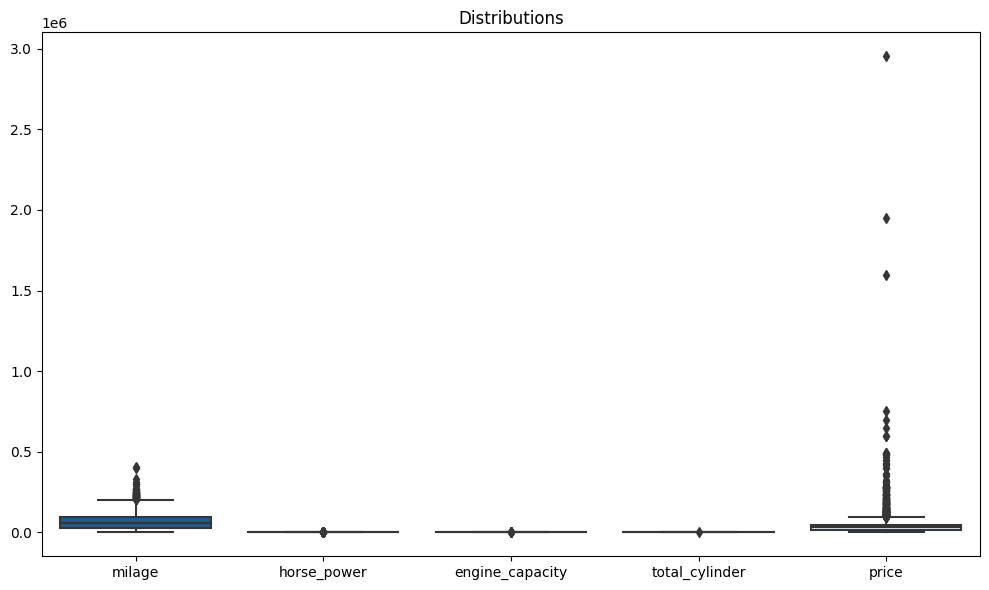

In [34]:
columns_to_check = ['milage', 'horse_power', 'engine_capacity', 'total_cylinder', 'price']

num_plots = len(columns_to_check)
num_cols = 1
num_rows = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

sns.boxplot(data=df[columns_to_check], palette='Blues_r', orient='v', ax=axes)
axes.set_xlabel('')
axes.set_title('Distributions', fontsize=12)
axes.set_xticklabels(axes.get_xticklabels(), ha='center')

plt.tight_layout()
plt.show()

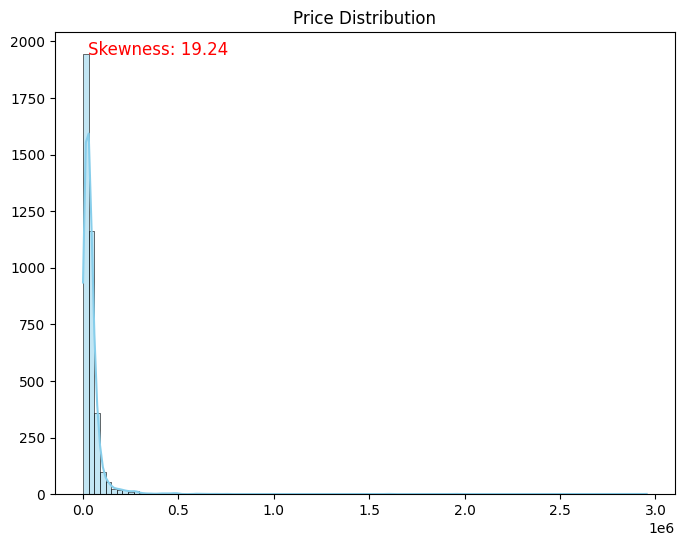

In [35]:
plt.figure(figsize=(8, 6))
ax = sns.histplot(df['price'], kde=True, color='skyblue', bins=100)

skewness_score = df['price'].skew()
text_position_x = df['price'].median()
text_position_y = ax.get_ylim()[1] * 0.95
ax.text(x=text_position_x, y=text_position_y, s=f'Skewness: {skewness_score:.2f}', ha='left', fontsize=12, color='red')

plt.title('Price Distribution', fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [36]:
mean = np.mean(df['price'])
std = np.std(df['price'])

upper_bound = mean + 3 * std
lower_bound = mean - 3 * std

outliers = []
for index, value in enumerate(df['price']):
    if value > upper_bound or value < lower_bound:
        outliers.append(index)

outliers_data = df.iloc[outliers]
print('Outliers data:')
print(outliers_data.to_string())

Outliers data:
     product_category          brand  milage  horse_power  engine_capacity  total_cylinder fuel_type transmission                                accident    price
462            Luxury    Rolls-Royce    2958          571                6              12  Gasoline    Automatic                           None reported   488880
463            Luxury    Rolls-Royce     850          563                6              12  Gasoline    Automatic                           None reported   314900
464            Luxury    Rolls-Royce     115          563                6              12  Gasoline    Automatic                           None reported   449995
466            Luxury    Rolls-Royce     398          563                6              12  Gasoline    Automatic                           None reported   695000
468            Luxury    Rolls-Royce    7585          571                6              12  Gasoline    Automatic                           None reported   599000
469    

### MULTIVARIATE ANALYSIS

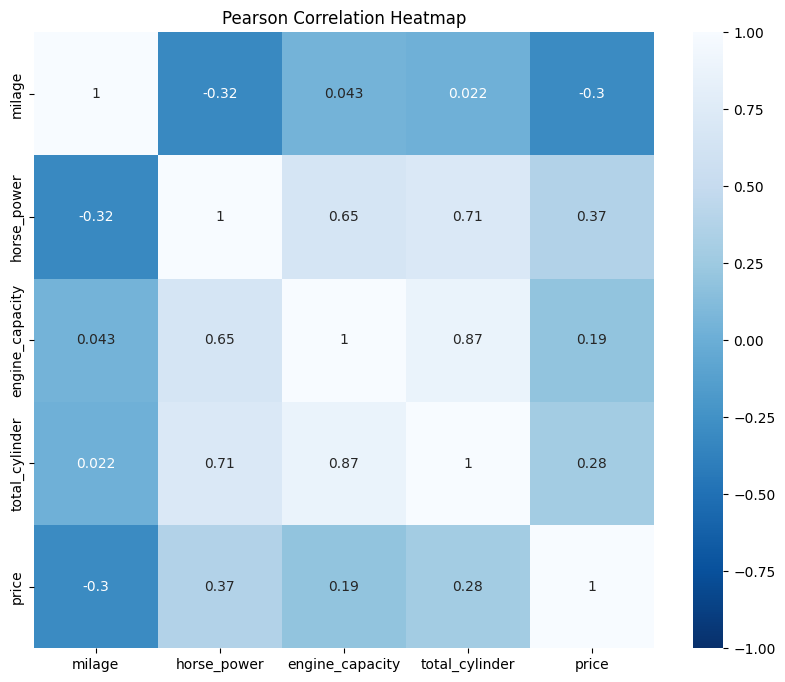

In [37]:
numerical_features = df.select_dtypes(include=['int', 'float']).columns
corr = df[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='Blues_r', annot_kws={'size': 10})
plt.title('Pearson Correlation Heatmap')
plt.show()

In [38]:
numeric = df[numerical_features]
numeric = sm.add_constant(numeric)

vif_numeric_pairwise = pd.DataFrame()
vif_numeric_pairwise['Variable'] = numeric.columns[1:]
vif_numeric_pairwise['VIF'] = [variance_inflation_factor(numeric.values, i) for i in range(1, numeric.shape[1])]

vif_threshold = 5

multicollinear_vars = []
for idx, row in vif_numeric_pairwise.iterrows():
    if row['VIF'] > vif_threshold:
        multicollinear_vars.append(row['Variable'])

print('VIF between Numerical Variables (Pairwise):')
print(vif_numeric_pairwise)
print('-'*90)

if multicollinear_vars:
    print('Multicollinearity symptoms were detected in the following variables:')
    for var in multicollinear_vars:
        print(var)
else:
    print('No multicollinearity symptoms were detected')

VIF between Numerical Variables (Pairwise):
          Variable   VIF
0           milage 1.369
1      horse_power 2.664
2  engine_capacity 4.275
3   total_cylinder 5.057
4            price 1.245
------------------------------------------------------------------------------------------
Multicollinearity symptoms were detected in the following variables:
total_cylinder


## FEATURE ENCODING

In [39]:
df['product_category'] = df['product_category'].replace({'Pick Up': 0, 'Compact': 1, 'SUV': 2, 'Sedan': 3, 'Sports': 4, 'Luxury': 5})

label_encoder = LabelEncoder()
features_to_label_encode = ['brand']

for feature in features_to_label_encode:
    df[feature] = label_encoder.fit_transform(df[feature])

transmission_order = {
    'Manual': 0,
    'Automatic': 1,
    'CVT': 2,
    'Dual-Clutch': 3
}
df['transmission'] = df['transmission'].map(transmission_order)

df['accident'] = df['accident'].replace({'At least 1 accident or damage reported': 0, 'None reported': 1})

df = pd.get_dummies(df, columns=['fuel_type'])

In [40]:
numerical_features = []
categorical_features = []
target_feature = 'price'

for column in df.columns:
    if column != target_feature:
        if df[column].dtype in ['int64', 'float64'] and column not in ['product_category', 'accident', 'transmission']:
            numerical_features.append(column)
        else:
            categorical_features.append(column)

print('Numerical Features:', numerical_features)
print('Categorical Features:', categorical_features)
print('Target Feature:', target_feature)

Numerical Features: ['milage', 'horse_power', 'engine_capacity', 'total_cylinder']
Categorical Features: ['product_category', 'brand', 'transmission', 'accident', 'fuel_type_Diesel', 'fuel_type_E85 Flex Fuel', 'fuel_type_Gasoline', 'fuel_type_Hybrid', 'fuel_type_Hydrogen', 'fuel_type_Plug-In Hybrid']
Target Feature: price


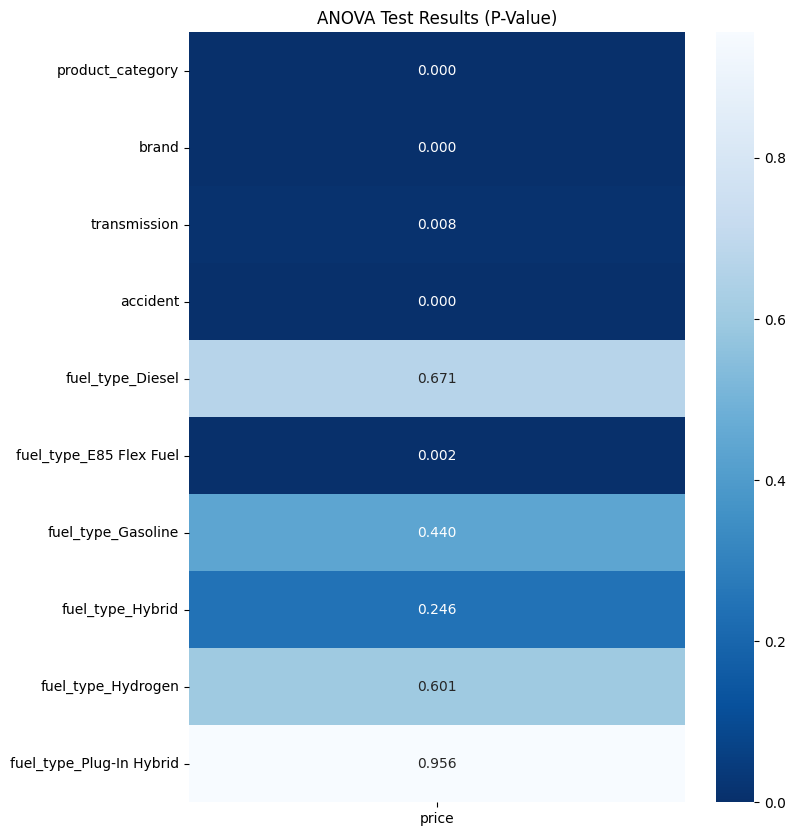

In [41]:
anova_results = {}
p_values_df = pd.DataFrame(index=categorical_features, columns=[target_feature], dtype=np.float64)

for cat_feat in categorical_features:
    group_data = [df[target_feature][df[cat_feat] == category] for category in df[cat_feat].unique()]
    F, p = f_oneway(*group_data)
    p_values_df.loc[cat_feat, target_feature] = round(p, 3)

p_values_df = p_values_df.applymap(lambda x: '{:.3f}'.format(x) if not pd.isna(x) else x)
plt.figure(figsize=(8, 10))
sns.heatmap(p_values_df.astype(float), cmap='Blues_r', annot=True, fmt='.3f')
plt.title('ANOVA Test Results (P-Value)')
plt.show()

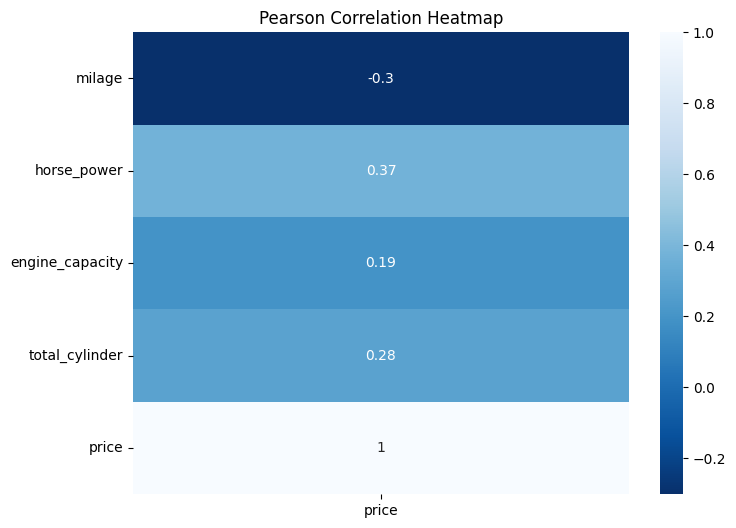

In [42]:
df_filtered = df[numerical_features + [target_feature]]
correlations = df_filtered.corr()[target_feature]

plt.figure(figsize=(8, 6))
sns.heatmap(correlations.to_frame(), annot=True, cmap='Blues_r', cbar=True)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [43]:
numeric = df_filtered[numerical_features]
numeric = sm.add_constant(numeric)

vif_numeric_pairwise = pd.DataFrame()
vif_numeric_pairwise['Variable'] = numeric.columns[1:]
vif_numeric_pairwise['VIF'] = [variance_inflation_factor(numeric.values, i) for i in range(1, numeric.shape[1])]

vif_threshold = 5

multicollinear_vars = []
for idx, row in vif_numeric_pairwise.iterrows():
    if row['VIF'] > vif_threshold:
        multicollinear_vars.append(row['Variable'])

print('VIF between Numerical and Target Variables (Pairwise):')
print(vif_numeric_pairwise)
print('-' * 90)

if multicollinear_vars:
    print('Multicollinearity symptoms were detected in the following variables:')
    for var in multicollinear_vars:
        print(var)
else:
    print('No multicollinearity symptoms were detected')

VIF between Numerical and Target Variables (Pairwise):
          Variable   VIF
0           milage 1.301
1      horse_power 2.610
2  engine_capacity 4.218
3   total_cylinder 4.927
------------------------------------------------------------------------------------------
No multicollinearity symptoms were detected


## TRAIN TEST SPLIT

In [44]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## FEATURE SELECTION

In [45]:
X_train = X_train.astype(int)

In [46]:
X_cons = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     55.24
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          2.67e-129
Time:                        13:50:22   Log-Likelihood:                -37864.
No. Observations:                2984   AIC:                         7.576e+04
Df Residuals:                    2970   BIC:                         7.584e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
product_category        

In [47]:
vif = pd.DataFrame()
vif['Variable'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif)

                    Variable    VIF
0           product_category  1.272
1                      brand  1.117
2                     milage  1.418
3                horse_power  2.823
4            engine_capacity  5.171
5             total_cylinder  5.259
6               transmission  1.033
7                   accident  1.102
8           fuel_type_Diesel  2.100
9    fuel_type_E85 Flex Fuel  2.349
10        fuel_type_Gasoline 31.756
11          fuel_type_Hybrid  2.826
12        fuel_type_Hydrogen  1.013
13  fuel_type_Plug-In Hybrid  1.262


In [48]:
X_train.drop(columns=['fuel_type_Gasoline'], inplace=True)
X_test.drop(columns=['fuel_type_Gasoline'], inplace=True)

In [49]:
train_to_drop = X_train[(X_train['fuel_type_Diesel'] == 0) & 
                        (X_train['fuel_type_E85 Flex Fuel'] == 0) & 
                        (X_train['fuel_type_Hybrid'] == 0) & 
                        (X_train['fuel_type_Hydrogen'] == 0) & 
                        (X_train['fuel_type_Plug-In Hybrid'] == 0)].index

X_train.drop(index=train_to_drop, inplace=True)
y_train.drop(index=train_to_drop, inplace=True)

test_to_drop = X_test[(X_test['fuel_type_Diesel'] == 0) & 
                        (X_test['fuel_type_E85 Flex Fuel'] == 0) & 
                        (X_test['fuel_type_Hybrid'] == 0) & 
                        (X_test['fuel_type_Hydrogen'] == 0) & 
                        (X_test['fuel_type_Plug-In Hybrid'] == 0)].index

X_test.drop(index=test_to_drop, inplace=True)
y_test.drop(index=test_to_drop, inplace=True)

## MODEL TRAINING

In [50]:
regression = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor()
}

results = []

for model_name, model in regression.items():

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    result = {
        'Model': model_name,
        'Train MAE': mae_train,
        'Test MAE': mae_test,
        'Train RMSE': rmse_train,
        'Test RMSE': rmse_test,
        'Train R2': r2_train,
        'Test R2': r2_test
    }
    results.append(result)

results_df = pd.DataFrame(results)
print(results_df.to_string())

               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  Test R2
0  Linear Regression  10401.044 10781.082   16052.973  15567.899     0.693    0.667
1      Decision Tree      6.579 11252.066      90.685  17427.603     1.000    0.583
2      Random Forest   3263.323  7819.553    5283.882  11886.111     0.967    0.806
3  Gradient Boosting   5275.265  8075.063    7296.949  11551.551     0.937    0.817
4            XGBoost    413.137  8356.440     589.052  11970.838     1.000    0.803


## MODEL EVALUATION

In [51]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), ['milage', 'horse_power', 'engine_capacity', 'total_cylinder'])
    ],
    remainder='passthrough'
)

pipeline_lr = Pipeline(steps = [['scaler', preprocessor],
                                ['regressor', LinearRegression()]])

kfold = KFold(n_splits=5,
              shuffle=True,
              random_state=42)
    
param_dist_lr = {
    'regressor__fit_intercept': [True, False]
}

random_search_lr = RandomizedSearchCV(estimator=pipeline_lr,
                                       param_distributions=param_dist_lr,
                                       n_iter=1000,
                                       scoring=None,
                                       cv=kfold,
                                       verbose=2,
                                       random_state=42,
                                       n_jobs=-1,
                                       error_score='raise')

random_search_lr.fit(X_train, y_train)
best_linear_reg_model = random_search_lr.best_estimator_

y_pred_test_lr = best_linear_reg_model.predict(X_test)

mae_test_lr = mean_absolute_error(y_test, y_pred_test_lr)
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
r2_test_lr = r2_score(y_test, y_pred_test_lr)

print('Best Parameters for Linear Regression:', random_search_lr.best_params_)
print('-'*90)
print('MAE Score for Linear Regression:', mae_test_lr)
print('RMSE Score for Linear Regression:', rmse_test_lr)
print('R-Squared Score for Linear Regression:', r2_test_lr)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters for Linear Regression: {'regressor__fit_intercept': False}
------------------------------------------------------------------------------------------
MAE Score for Linear Regression: 10781.081712873405
RMSE Score for Linear Regression: 15567.899254857552
R-Squared Score for Linear Regression: 0.6669922977309259


### GRADIENT BOOSTING

## RESIDUAL TEST

### LINEAR REGRESSION

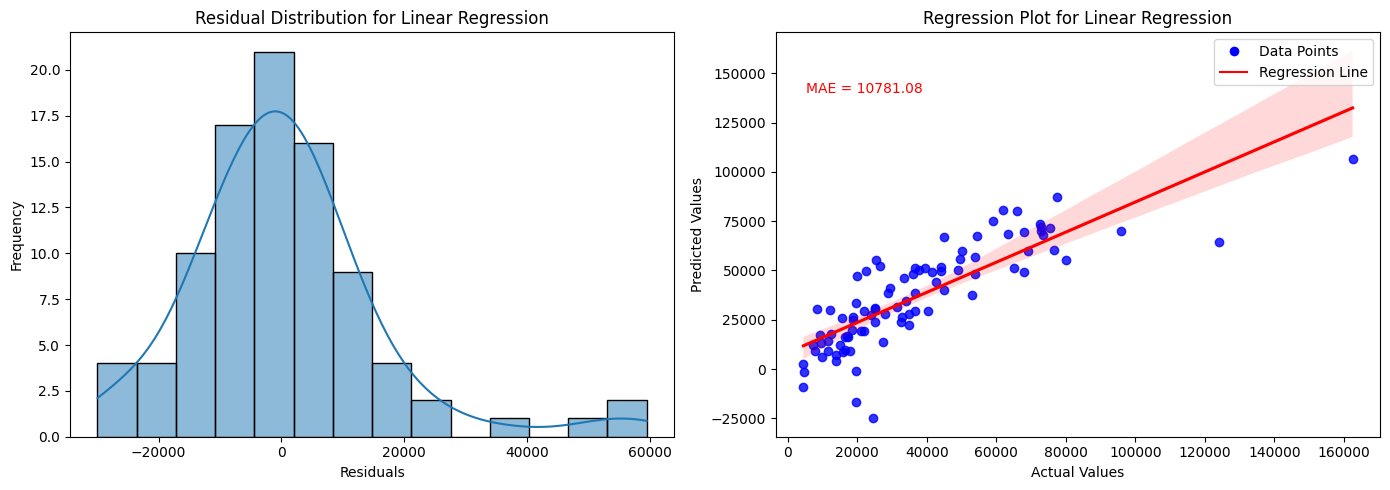

In [53]:
residual_lr = y_test - y_pred_test_lr

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.histplot(residual_lr, kde=True, ax=axes[0])
axes[0].set_title('Residual Distribution for Linear Regression')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')

sns.regplot(x=y_test, y=y_pred_test_lr, scatter_kws={'color':'blue'}, line_kws={'color':'red'}, ax=axes[1])
axes[1].set_title('Regression Plot for Linear Regression')
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')

scatter_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Data Points')
line_legend = plt.Line2D([0], [0], color='red', label='Regression Line')
axes[1].legend(handles=[scatter_legend, line_legend])

mae = mean_absolute_error(y_test, y_pred_test_lr)
axes[1].annotate(f'MAE = {mae:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='red')

plt.tight_layout()
plt.show()

### GRADIENT BOOSTING

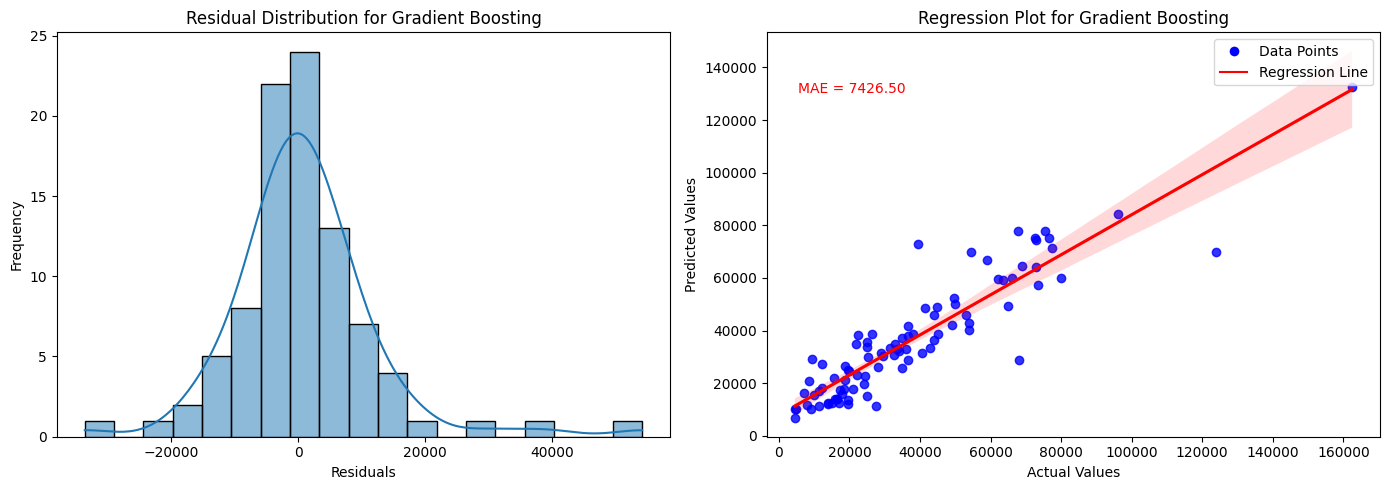

In [54]:
residual_gb = y_test - y_pred_test_gb

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.histplot(residual_gb, kde=True, ax=axes[0])
axes[0].set_title('Residual Distribution for Gradient Boosting')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')

sns.regplot(x=y_test, y=y_pred_test_gb, scatter_kws={'color':'blue'}, line_kws={'color':'red'}, ax=axes[1])
axes[1].set_title('Regression Plot for Gradient Boosting')
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')

scatter_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Data Points')
line_legend = plt.Line2D([0], [0], color='red', label='Regression Line')
axes[1].legend(handles=[scatter_legend, line_legend])

mae = mean_absolute_error(y_test, y_pred_test_gb)
axes[1].annotate(f'MAE = {mae:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='red')

plt.tight_layout()
plt.show()

## FEATURE IMPORTANCES

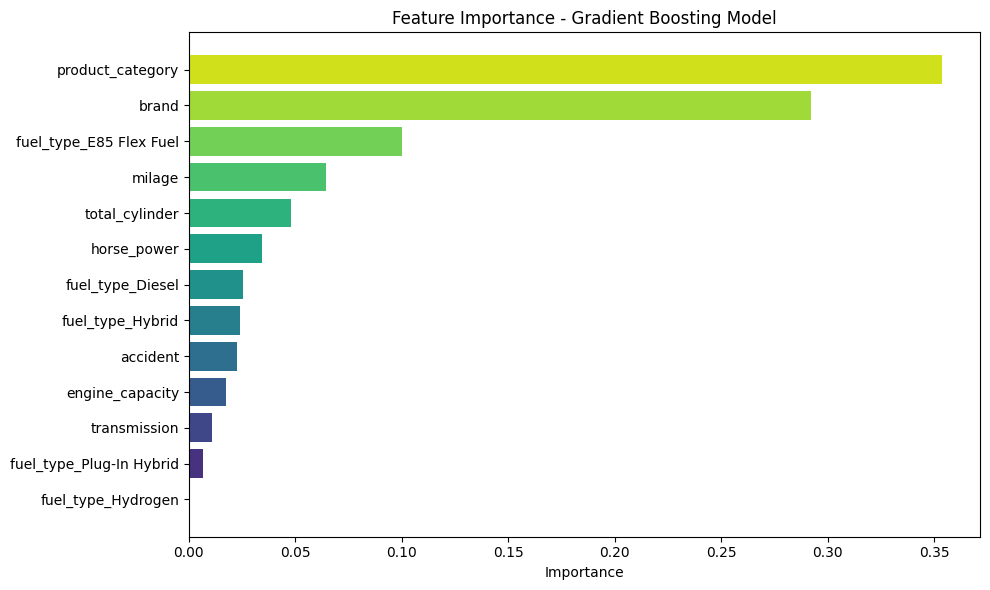

In [55]:
feature_importance = best_gradient_boost_model.named_steps['regressor'].feature_importances_
feature_names = X_train.columns
indices = np.argsort(feature_importance)[::1]

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

axes.barh(range(len(feature_names)), feature_importance[indices], color=sns.color_palette("viridis", len(feature_names)))
axes.set_yticks(range(len(feature_names)))
axes.set_yticklabels(np.array(feature_names)[indices])
axes.set_xlabel('Importance')
axes.set_title('Feature Importance - Gradient Boosting Model')

plt.tight_layout()
plt.show()